In [3]:
import numpy as np
import pandas as pd
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
%matplotlib inline

In [5]:
os.chdir("developer_survey_2017")

In [6]:
data_file = "survey_results_public.csv"
desc_file = "survey_results_schema.csv"
df = pd.read_csv(data_file)
df_desc = pd.read_csv(desc_file)

# Create relevant df and drop nulls

In [7]:
relevant_cols = ['Professional','EmploymentStatus','Country','CompanySize',
                 'YearsCodedJob','ProblemSolving','BuildingThings',
                 'LearningNewTech','InvestTimeTools','ChallengeMyself',
                 'FriendsDevelopers','KinshipDevelopers','CareerSatisfaction',
                'EnjoyDebugging']
df = df[relevant_cols]


In [8]:
# create df with full time employed professional developers
prof_dev = df['Professional']=='Professional developer'
fte = df['EmploymentStatus'] == 'Employed full-time'
df_dev_fte = df[prof_dev & fte]

print("{} out of {} respondents are full-time employed professional developers".format(len(df_dev_fte), len(df)))


30211 out of 51392 respondents are full-time employed professional developers


In [9]:
# drop cols that won't be used in analysis
df_dev_fte.drop(columns=['Professional','EmploymentStatus'], inplace=True)
    # same as below
# df_dev_fte.drop(labels=['Professional','EmploymentStatus'], axis=1, inplace=True)


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
# view percent missing data in relevant columns
missing_data_cols = df_dev_fte.isnull().sum().sort_values()
print("percent missing data in relevant columns:")
round((missing_data_cols/df.shape[0])*100, 2)

percent missing data in relevant columns:


Country                0.00
CompanySize            0.07
YearsCodedJob          0.45
CareerSatisfaction     0.54
LearningNewTech       21.67
ProblemSolving        21.70
BuildingThings        21.73
FriendsDevelopers     21.91
ChallengeMyself       22.03
InvestTimeTools       22.09
KinshipDevelopers     22.32
EnjoyDebugging        23.14
dtype: float64

In [11]:
# drop rows w/any nans
df_dev_fte_no_nans = df_dev_fte.dropna(axis=0, how='any')

# remove missing values from CompanySize
companysize_nan1 = df_dev_fte_no_nans['CompanySize'] != "I don't know"
companysize_nan2 = df_dev_fte_no_nans['CompanySize'] != "I prefer not to answer"
df_dev_fte_no_nans = df_dev_fte_no_nans[companysize_nan1 & companysize_nan2]

print("{} out of {} full-time employed professional developers do not have missing data".format(len(df_dev_fte_no_nans), len(df_dev_fte)))



11619 out of 30211 full-time employed professional developers do not have missing data


# Feature engineering

In [12]:
def recode_country(x):
    if x == 'United States':
        return 1
    else: 
        return 0
df_dev_fte_no_nans['Country'] = df_dev_fte_no_nans['Country'].apply(recode_country)
df_dev_fte_no_nans.rename(columns={'Country':'US'}, inplace=True)

In [13]:
CompanySize_mapping = {'Fewer than 10 employees': 1, '10 to 19 employees': 2, 
                       '20 to 99 employees': 3, '100 to 499 employees': 4, 
                       '500 to 999 employees': 5, '1,000 to 4,999 employees': 6,
                       '5,000 to 9,999 employees': 7, '10,000 or more employees': 8}

df_dev_fte_no_nans['CompanySize'] = df_dev_fte_no_nans['CompanySize'].replace(CompanySize_mapping)


In [14]:
def recode_YearsCodedJob(x):
    return x[:2]

YearsCoded_mapping = {'Le' : 0}

df_dev_fte_no_nans['YearsCodedJob'] = df_dev_fte_no_nans['YearsCodedJob'].apply(recode_YearsCodedJob)
df_dev_fte_no_nans['YearsCodedJob'] = df_dev_fte_no_nans['YearsCodedJob'].replace(YearsCoded_mapping)
df_dev_fte_no_nans['YearsCodedJob'] = pd.to_numeric(df_dev_fte_no_nans['YearsCodedJob'])

In [15]:
likert_mapping = {'Strongly disagree': 1, 'Disagree': 2, 
                  'Somewhat agree': 3, 'Agree': 4, 'Strongly agree': 5}

likert_cols = ['ProblemSolving', 'BuildingThings', 'LearningNewTech',
               'InvestTimeTools', 'ChallengeMyself', 'FriendsDevelopers',
               'KinshipDevelopers','EnjoyDebugging']

for col in likert_cols: 
    df_dev_fte_no_nans[col] = df_dev_fte_no_nans[col].replace(likert_mapping)

# Visualize distributions of features and response variables

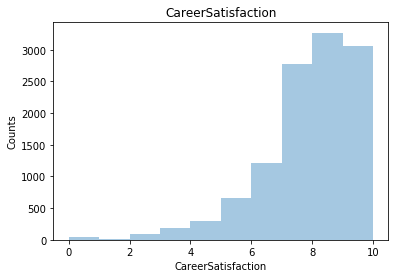

CareerSatisfaction Average:  7.490145451415785


In [29]:
# Career Satisfaction is left skewed
# df_dev_fte_no_nans['CareerSatisfaction'].hist();
sns.distplot(df_dev_fte_no_nans['CareerSatisfaction'], kde=False, bins=10); 
plt.title('CareerSatisfaction')
plt.ylabel('Counts')
plt.show()

print("CareerSatisfaction Average: ", df_dev_fte_no_nans['CareerSatisfaction'].mean())


In [67]:
# # similar satisfaction for US and non-US respondents
# co_hist1 = df_dev_fte_no_nans[df_dev_fte_no_nans['US'] == 0]
# co_hist2 = df_dev_fte_no_nans[df_dev_fte_no_nans['US'] == 1]
# sns.distplot(co_hist1['CareerSatisfaction'], kde=False, bins=10, label='non-United States');
# sns.distplot(co_hist2['CareerSatisfaction'], kde=False, bins=10, label='United States');
# plt.legend()

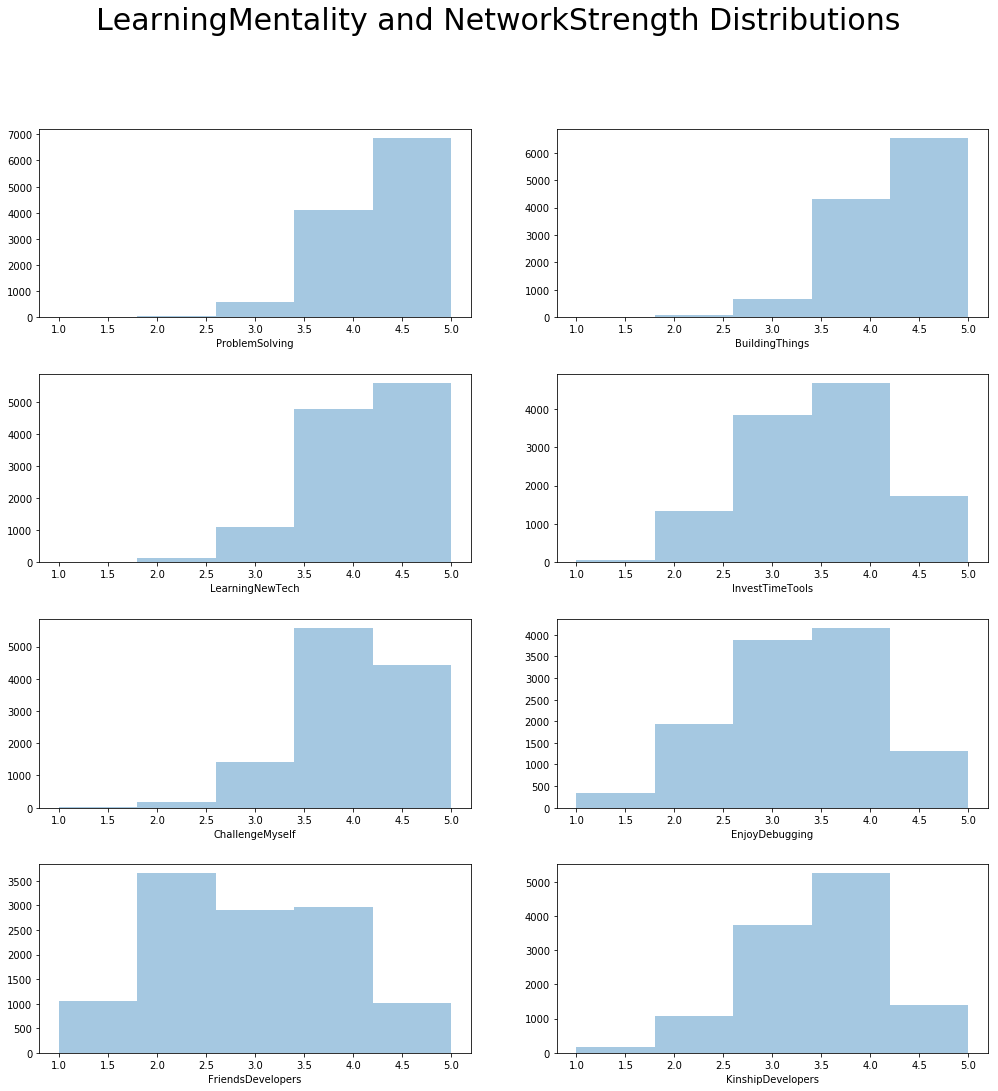

In [92]:
# likert variables (main variables of interest) mostly left-skewed
# df_dev_fte_no_nans[likert_cols].hist(bins=5); 
figure, axs = plt.subplots(nrows=4, ncols=2, figsize = (17, 17))
figure.suptitle('LearningMentality and NetworkStrength Distributions', size=30);
# plt.gca().set_title('LearningMentality Distributions')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
    
sns.distplot(df_dev_fte_no_nans['ProblemSolving'], kde=False, bins=5, ax=axs[0][0]); 
sns.distplot(df_dev_fte_no_nans['BuildingThings'], kde=False, bins=5, ax=axs[0][1]); 
sns.distplot(df_dev_fte_no_nans['LearningNewTech'], kde=False, bins=5, ax=axs[1][0]); 
sns.distplot(df_dev_fte_no_nans['InvestTimeTools'], kde=False, bins=5, ax=axs[1][1]); 
sns.distplot(df_dev_fte_no_nans['ChallengeMyself'], kde=False, bins=5, ax=axs[2][0]);
sns.distplot(df_dev_fte_no_nans['EnjoyDebugging'], kde=False, bins=5, ax=axs[2][1]);
sns.distplot(df_dev_fte_no_nans['FriendsDevelopers'], kde=False, bins=5, ax=axs[3][0]); 
sns.distplot(df_dev_fte_no_nans['KinshipDevelopers'], kde=False, bins=5, ax=axs[3][1]); 



In [19]:
# individual plots 
# for col in likert_cols: 
#     sns.distplot(df_dev_fte_no_nans[col], kde=False, bins=5); 
#     plt.show()


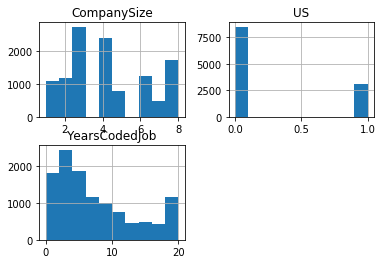

In [20]:
# control variables 
# CompanySize - somewhat normal distribution w/a fair amount of 10k or more employees
# country - mostly non US
# years coded on the job right skewed with a fair amount of 20+ respondents
df_dev_fte_no_nans[['US','CompanySize','YearsCodedJob']].hist();

In [21]:
# similar to heatmap, but not as useful
# sns.pairplot(df_dev_fte_no_nans)

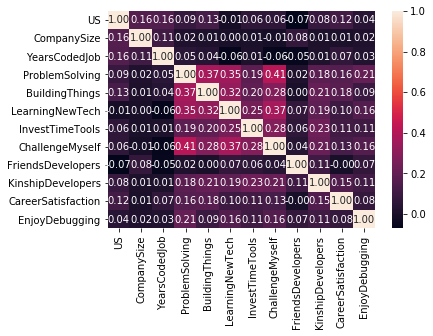

In [22]:
sns.heatmap(df_dev_fte_no_nans.corr(), annot=True, fmt=".2f");

## Findings
- Career Satisfaction is left skewed with most of the responses lying on the upper end of the scale (horray!)

- LearningMentality variables (ProblemSolving, BuildingThings, LearningNewTech, InvestTimeTools, ChallengeMyself, FriendsDevelopers) are relatively left skewed with more full time employed developer respondents favoring a learning mentality. 

- NetworkStrength variables (KinshipDevelopers, EnjoyDebugging) are relatively normally distributed when compared to LearningMentality variables, indicating less existence of strong networks than existence of learning mentality amongst respondents. 

- LearningMentality variables are relatively more correlated with one another than NetworkStrength variables. 

- Note, since the LearningMentality variables seem to be mostly left skewed, I'm opting to not impute the data to preserve variance for these fields. We do have a fair amount of data points without missing data ~11.6k, so proceeding without imputing values will still leave us with a fair amount of data.


# Standardize variables and run models


In [27]:

def run_lm_model(data, transform_cols, scale_or_normalize): 
    
    """
    inputs: 
        data: dataframe w/X and Y variables of interest. 
            must include CareerSatisfaction as response variable
        transform_cols: columns to apply standard scaler to 
        scale_or_normalize: options - scale or normalize
    return: r2, intercept, coefficients dataframe 
    
    """

    # scale IVs
    # scaler = StandardScaler()  
        # https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc
        # creates a more normal distribution
    
    if scale_or_normalize == 'scale':
        scaler = MinMaxScaler() 
            # use this for coefficient interpretability 
        data = pd.DataFrame.copy(data)
        data[transform_cols] = scaler.fit_transform(data[transform_cols])
    
    if scale_or_normalize == 'normalize':
        normalizer = Normalizer() 
            # use this to approach assumption of normal distribution for IVs
        data = pd.DataFrame.copy(data)
        data[transform_cols] = normalizer.fit_transform(data[transform_cols])


    # create DV and IV dfs
    y = data['CareerSatisfaction'] 
    X = data.drop(columns = ['CareerSatisfaction'])

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 
    
    # use OLS
    lm_model = LinearRegression() # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict and score the model
    y_test_preds = lm_model.predict(X_test) 
    r2 = r2_score(y_test, y_test_preds)
    intercept = lm_model.intercept_

    # create coefficient dataframe for feature importance
    coeff_df = pd.DataFrame(lm_model.coef_, X.columns, 
                        columns = ['Coefficient']) 
    coeff_df['abs_coeff'] = np.abs(coeff_df['Coefficient'])
    coeff_df.sort_values(by=['abs_coeff'], ascending=False, inplace=True)
    
    return r2, intercept, coeff_df, data



In [32]:
# run full model w/scaled data
# transform all cols except for country and careersatisfaction
transform_cols = ['CompanySize','YearsCodedJob', 'ProblemSolving',
                  'BuildingThings','LearningNewTech','InvestTimeTools',
                  'ChallengeMyself','FriendsDevelopers','KinshipDevelopers',
                 'EnjoyDebugging']

r2_s, intercept_s, coeff_df_s, data_s = run_lm_model(data=df_dev_fte_no_nans, 
                                                     transform_cols=transform_cols,
                                                     scale_or_normalize = 'scale')

CareerSatisfaction_mean = df_dev_fte_no_nans['CareerSatisfaction'].describe()['mean']
print("r2: ",r2_s)
print("\nintercept (expected value for those not in US w/mean values: ", intercept_s)
print("CareerSatisfaction mean: ", CareerSatisfaction_mean)
print("\ncoefficients: \n", coeff_df_s) 

r2:  0.06579119329125493

intercept (expected value for those not in US w/mean values:  4.721483326718603
CareerSatisfaction mean:  7.490145451415785

coefficients: 
                    Coefficient  abs_coeff
BuildingThings        0.890613   0.890613
ProblemSolving        0.804116   0.804116
KinshipDevelopers     0.801129   0.801129
InvestTimeTools       0.369352   0.369352
US                    0.307940   0.307940
YearsCodedJob         0.272607   0.272607
ChallengeMyself       0.250551   0.250551
EnjoyDebugging        0.207847   0.207847
LearningNewTech       0.141243   0.141243
FriendsDevelopers    -0.115004   0.115004
CompanySize          -0.084651   0.084651


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [33]:
# run full model w/normalized data
# transform all cols except for country and careersatisfaction
transform_cols = ['CompanySize','YearsCodedJob', 'ProblemSolving',
                  'BuildingThings','LearningNewTech','InvestTimeTools',
                  'ChallengeMyself','FriendsDevelopers','KinshipDevelopers',
                 'EnjoyDebugging']

r2_n, intercept_n, coeff_df_n, data_n = run_lm_model(data=df_dev_fte_no_nans, 
                                                     transform_cols=transform_cols,
                                                     scale_or_normalize = 'normalize')

CareerSatisfaction_mean = df_dev_fte_no_nans['CareerSatisfaction'].describe()['mean']
print("r2: ",r2_n)
print("\nintercept (expected value for those not in US w/mean values: ", intercept_n)
print("CareerSatisfaction mean: ", CareerSatisfaction_mean)
print("\ncoefficients: \n", coeff_df_n) 


r2:  0.02240420659528386

intercept (expected value for those not in US w/mean values:  6.485540862077279
CareerSatisfaction mean:  7.490145451415785

coefficients: 
                    Coefficient  abs_coeff
KinshipDevelopers     2.292429   2.292429
FriendsDevelopers    -0.934797   0.934797
InvestTimeTools       0.886115   0.886115
LearningNewTech      -0.653785   0.653785
YearsCodedJob         0.590549   0.590549
US                    0.434000   0.434000
BuildingThings        0.348291   0.348291
EnjoyDebugging        0.291611   0.291611
ProblemSolving        0.274235   0.274235
CompanySize          -0.267734   0.267734
ChallengeMyself       0.173415   0.173415


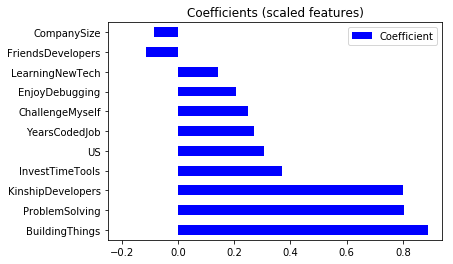

In [38]:
coeff_df_s.plot(y='Coefficient', kind='barh', use_index=True, color='blue',
             xlim=-0.25, title='Coefficients (scaled features)');

## Findings
Though normalizing features approaches OLS assumption to a greater extent than min max scaling, scaling the data allows for greater interpretability and higher R-squared (explained variance in CareerSatisfaction). With these likert variables in particluar, interpreability is key to compare coefficients. So, we'll proceed with MinMaxScaling. 

Example interpretations
- MinMaxScaling - When variables are scaled between 1 and 0, a one unit increase in BuildingThings corresponds with a 0.89 increase in CareerSatisfaction.
- Normalization - relatively unknown interpretation

With the scaled model, our results indicate that LearningMentality AND NetworkStrength variables are important for CareerSatisfaction. Surprisingly, those who have relatively more friends who are mostly developers have lower CareerSatisfaction.

Let's see if we can simplify this model further.


# Reduced model with aggregated features

In [39]:
# create aggregate variables for LearningMentality and NetworkStrength
    # because individual variables may be capturing similar concepts, affecting results

# BuildingThings and KinshipDevelopers are both the most important
# create df for linear regression w/reduced variables
# create index variables for these learning mentality and network strength
df_dev_fte_no_nans_reduced = pd.DataFrame.copy(df_dev_fte_no_nans)
df_dev_fte_no_nans_reduced['LearningMentality'] = df_dev_fte_no_nans_reduced[['BuildingThings','ProblemSolving','InvestTimeTools','ChallengeMyself','LearningNewTech']].sum(axis=1)
df_dev_fte_no_nans_reduced['NetworkStrength'] = df_dev_fte_no_nans_reduced[['KinshipDevelopers','FriendsDevelopers']].sum(axis=1)

reduced_cols = ['US', 'CompanySize', 'YearsCodedJob','CareerSatisfaction', 
                'LearningMentality', 'NetworkStrength']
df_dev_fte_no_nans_reduced = df_dev_fte_no_nans_reduced[reduced_cols]


In [41]:
reduced_X = ['CompanySize', 'YearsCodedJob',
             'LearningMentality', 'NetworkStrength']
r2_reduced, intercept_reduced, coeff_df_reduced, data_reduced = run_lm_model(data=df_dev_fte_no_nans_reduced, 
                                                                             transform_cols=reduced_X,
                                                                            scale_or_normalize='scale')
print("r2: ",r2_reduced)
print("\nintercept (expected value for those in US w/mean values: ", intercept_reduced)
print("CareerSatisfaction mean: ", CareerSatisfaction_mean)
print("\ncoefficients: \n", coeff_df_reduced) 

r2:  0.05550967143998364

intercept (expected value for those in US w/mean values:  4.952841104302392
CareerSatisfaction mean:  7.490145451415785

coefficients: 
                    Coefficient  abs_coeff
LearningMentality     2.635772   2.635772
NetworkStrength       0.436797   0.436797
US                    0.363798   0.363798
YearsCodedJob         0.324887   0.324887
CompanySize          -0.115835   0.115835


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


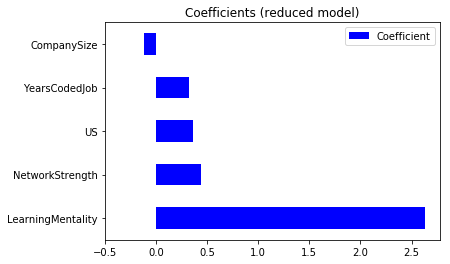

In [42]:
coeff_df_reduced.plot(y='Coefficient', kind='barh', use_index=True, color='blue',
             xlim=-0.5, title='Coefficients (reduced model)');

In [46]:
# # view simple linear regression for main variables of interest

# # transform data
# transform_cols = ['LearningMentality', 'NetworkStrength']
# sc = MinMaxScaler()
# data_scaled = pd.DataFrame.copy(df_dev_fte_no_nans_reduced)
# data_scaled[transform_cols] = sc.fit_transform(data_scaled[transform_cols])

# # jitter allows us to view density
#     # jitter displays values as slightly over max for x and y
# for x in transform_cols:
#     sns.lmplot(x, 'CareerSatisfaction', data_scaled,
#               x_jitter = 0.3, y_jitter=0.3)

## Findings

If we create a more parsimonious model by creating aggregate variables for LearningMentality and NetworkStrength, we observe that LearningMentality has a more substantial relationship with CareerSatisfaction than NetworkStrength. However, the results from the full model indicated this as well when we observed that those who have relatively more friends who are mostly developers have lower CareerSatisfaction.

Let's see what we can learn from creating LearningMentality and NetworkingStrength clusters.

# Career satisfaction for LearningMentality and NetworkingStrength clusters

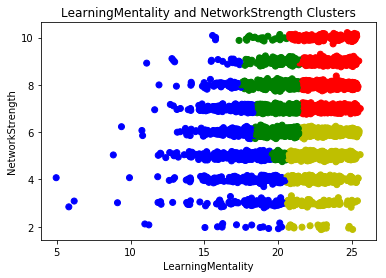

In [47]:

## clustering algo 
estimator = KMeans(n_clusters=4, random_state = 2)
cluster_df = df_dev_fte_no_nans_reduced[['LearningMentality','NetworkStrength']]
estimator.fit(cluster_df)

# Clusters are given in the labels_ attribute
labels = estimator.labels_

# Plot the data
#jitter function to show density of points

# https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def set_colors(labels, colors='rgbykcm'):
    colored_labels = []
    for label in labels:
        colored_labels.append(colors[label])
    return colored_labels

# labels: 0-red, 1-green, 2-blue, 3-yellow
    # 0/red - high lm and high nw. Networking learners
    # 1/green - somewhat high lm and high nw. networking moderate-learners
    # 2/blue - low lm and any nw. erratic networking anti-learners 
    # 3/yellow - high lm and lower nw. recluse learners 
colors = set_colors(labels)
plt.scatter(rand_jitter(df_dev_fte_no_nans_reduced['LearningMentality']), rand_jitter(df_dev_fte_no_nans_reduced['NetworkStrength']), c=colors)
plt.title('LearningMentality and NetworkStrength Clusters')
plt.xlabel("LearningMentality")
plt.ylabel("NetworkStrength")
plt.show()

In [48]:
# labels _df
labels_df = pd.DataFrame({"labels":labels, "index":cluster_df.index.tolist()})

# merge to get other features
clusters_df = pd.merge(labels_df, df_dev_fte_no_nans_reduced, how='inner', left_on='index', right_index=True)


# name the labels w/something substantive
def name_labels(x):

    if x == 0:
        return 'networking learners'
    if x == 1: 
        return 'networking moderate-learners'
    if x == 2:
        return 'erratic networking anti-learners'
    if x == 3:
        return 'recluse learners'

clusters_df['cluster'] = clusters_df['labels'].apply(name_labels)     

# drop unnecessary cols
clusters_df.drop(columns=['index', 'LearningMentality','NetworkStrength'], inplace=True)
# clusters_df=pd.get_dummies(data=clusters_df, columns=['labels'])

In [64]:
# create agg data 
clusters_counts = clusters_df['cluster'].value_counts()
clusters_means = clusters_df.groupby(['cluster']).mean()
# merge agg data
clusters_info = pd.merge(clusters_means, pd.DataFrame(clusters_counts), left_index=True, right_index=True)
clusters_info.sort_values(by='CareerSatisfaction', inplace=True)

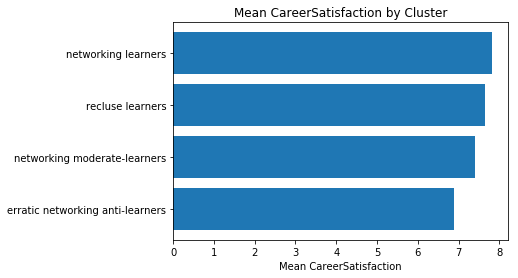

In [66]:
plt.barh(clusters_info.index, clusters_info['CareerSatisfaction'])
plt.title('Mean CareerSatisfaction by Cluster')
plt.xlabel('Mean CareerSatisfaction')
plt.show()

# Findings

- Clustering LearningMentality and NetworkStrength allows use to label users according to these two aggregated dimensions. 

- networking learners appear to have the highest CareerSatisfaction, followed by recluse learners, networking moderate-learners, then erratic networking anti-learners.